In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os,glob
import random
import time

import cv2 
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from natsort import natsorted

from model.ResNet import Bottleneck, ResNet, ResNet50

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [6]:
class ImageTransform() :
    def __init__(self) :
        self.data_transform = {
            'train' : transforms.Compose([
                # transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                # transforms.Resize(256),
                # transforms.CenterCrop(resize),
                transforms.ToTensor(),
                # transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [7]:
Model = ResNet50(num_classes=5, channels=1).to(device)

In [8]:
# bph normal stricture ub : 204개 (train : valid : test = 163 : 21 : 20)
# oab : 84개 (train : valid : test = 67 : 9 : 8)

bph_dir = './pre_crop_resize_204/bph'
normal_dir = './pre_crop_resize_204/normal'
oab_dir = './pre_crop_resize_204/oab'
stricture_dir = './pre_crop_resize_204/stricture'
ub_dir = './pre_crop_resize_204/ub'

bph_images_filepaths = sorted([os.path.join(bph_dir, f) for f in os.listdir(bph_dir)])
normal_images_filepaths = sorted([os.path.join(normal_dir, f) for f in os.listdir(normal_dir)])
oab_images_filepaths = sorted([os.path.join(oab_dir, f) for f in os.listdir(oab_dir)])
stricture_images_filepaths = sorted([os.path.join(stricture_dir, f) for f in os.listdir(stricture_dir)])
ub_images_filepaths = sorted([os.path.join(ub_dir, f) for f in os.listdir(ub_dir)])

test_image_filepaths = [*bph_images_filepaths[184:], *normal_images_filepaths[184:], *oab_images_filepaths[76:], *stricture_images_filepaths[184:], *ub_images_filepaths[184:]]

test_correct_images_filepaths = [i for i in test_image_filepaths if cv2.imread(i) is not None]

test_images_filepaths = test_correct_images_filepaths

print("test images: ", len(test_images_filepaths))


test images:  86


In [9]:
## Eval Model

import pandas as pd
id_list = []
pred_list = []
_id = 0

model_dir = './experiment/pre_crop_204/'
best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[-1])
print('Model: {} loaded!'.format(natsorted(os.listdir(model_dir))[-1]))
Model.load_state_dict(best_model)

pred_class = 'None'

correct = 0
wrong = 0
bph_correct = 0
normal_correct = 0
oab_correct = 0
stricture_correct = 0
ub_correct = 0

with torch.no_grad() : 
    for test_path in test_images_filepaths :
        img = Image.open(test_path)
        _id = label = test_path.split('/')[-2]
        transform = ImageTransform()
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        Model.eval()
        outputs = Model(img)
        preds = F.softmax(outputs, dim=1)
        argmax_preds = np.argmax(preds.cpu()).tolist()
        
        if argmax_preds == 0 :
            pred_class = 'bph'
        elif argmax_preds == 1 :
            pred_class = 'normal'
        elif argmax_preds == 2 :
            pred_class = 'oab'
        elif argmax_preds == 3 :
            pred_class = 'stricture'
        elif argmax_preds == 4 :
            pred_class = 'ub'
                    
        id_list.append(_id)
        pred_list.append(pred_class)
        
        if _id == pred_class:
            correct+=1
        else:
            wrong+=1
        
        if _id == 'bph':
            if _id == pred_class:
                bph_correct += 1
        elif _id == 'normal':
            if _id == pred_class:
                normal_correct += 1
        elif _id == 'oab':
            if _id == pred_class:
                oab_correct += 1 
        elif _id == 'stricture':
            if _id == pred_class:
                stricture_correct += 1  
        elif _id == 'ub':
            if _id == pred_class:
                ub_correct += 1     
                                           
res = pd.DataFrame({
        'ground_truth' : id_list,
        'pred' : pred_list
})

res.sort_values(by='ground_truth', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./pre_crop_204.csv', index=False)

print("correct:", correct, "wrong: ", wrong)
print("total acc:",correct/(correct+wrong))
print('--each class acc--')
print("bph_acc: ", bph_correct/len(res.loc[res['ground_truth']=='bph']))
print("normal_acc: ", normal_correct/len(res.loc[res['ground_truth']=='normal']))
print("oab_acc: ", oab_correct/len(res.loc[res['ground_truth']=='oab']))
print("stricture_acc: ", stricture_correct/len(res.loc[res['ground_truth']=='stricture']))
print("ub_acc: ", ub_correct/len(res.loc[res['ground_truth']=='ub']))
        
    


/tmp/ipykernel_137221/3126269861.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[-1])


Model: 0.667_58_model.pt loaded!
correct: 57 wrong:  29
total acc: 0.6627906976744186
--each class acc--
bph_acc:  0.35
normal_acc:  0.95
oab_acc:  0.8333333333333334
stricture_acc:  0.95
ub_acc:  0.35


/tmp/ipykernel_137221/374954503.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[-1])


Model: 0.667_58_model.pt loaded!


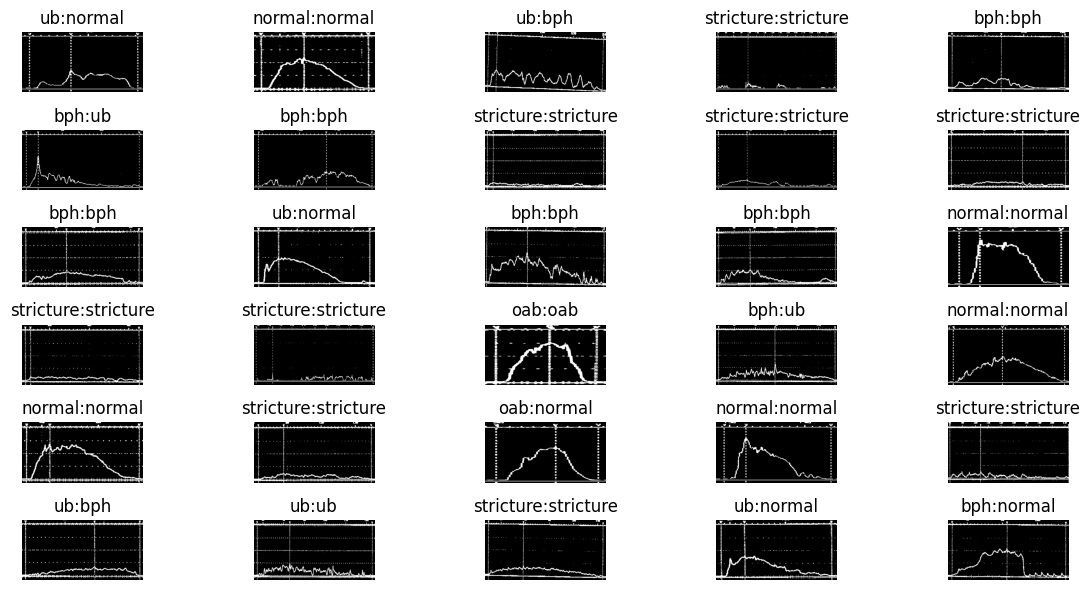

In [10]:
# Visualization GT : pred 
model_dir = './experiment/pre_crop_204/'
best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[-1])
print('Model: {} loaded!'.format(natsorted(os.listdir(model_dir))[-1]))
Model.load_state_dict(best_model)
pred_class = None

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
    rows = len(images_filepaths[:30]) // cols
    fig , ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    random.shuffle(images_filepaths)
    for i, image_filepath in enumerate(images_filepaths[:30]) :
        origin_img = Image.open(image_filepath)
        _id = label = image_filepath.split('/')[-2]
        transform = ImageTransform()
        img = transform(origin_img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        Model.eval()
        outputs = Model(img)
        preds = F.softmax(outputs, dim=1)
        argmax_preds = np.argmax(preds.cpu().detach().numpy()).tolist()
        
        if argmax_preds == 0 :
            pred_class = 'bph'
        elif argmax_preds == 1 :
            pred_class = 'normal'
        elif argmax_preds == 2 :
            pred_class = 'oab'
        elif argmax_preds == 3 :
            pred_class = 'stricture'
        elif argmax_preds == 4 :
            pred_class = 'ub'
                    
        ax.ravel()[i].imshow(origin_img, cmap=plt.cm.gray)
        ax.ravel()[i].set_title(label + ":" +pred_class)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)